# Fully hierarchical systematics calibration:

In this notebook, I will attempt a fully hierarchical calibration of systematics using simulated data from CHARA/PAVO. Previously, we have assumed all systematics remain constant between different stars. This may not be the case due to noise or various other variables that alter the systematics from star to star. Given a large enough ensemble of stars, we should be able to infer not only the individual systematics model for each star, but also the distribution of systematics across the entire sample. 

This notebook will explore two different kinds of systematics:

1. Baseline ripple

2. Uniform random systematic

In each case, I will start with a non-hierarchical test, where the systematic is constant across the ensemble, before proceeding to a hierarchical test where we infer both the systematic's parameters and its parent distribution.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

#this is the way I've found to get jax to use multiple CPU cores on Apple Silicon
import os
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=2"

import jax
import jax.numpy as jnp

import numpyro
from numpyro import distributions as dist, infer

import arviz as az

import corner

## Creating an (approximation) of the CHARA array

Once again, we start with the same approximation of CHARA as before:

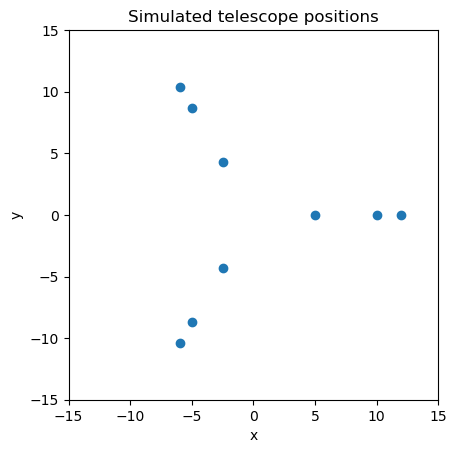

In [3]:
thetas = jnp.array([0,0,0,120,120,120,240,240,240])
radii = jnp.array([5,10,12,5,10,12,5,10,12])

station_x = radii * jnp.cos(thetas*jnp.pi/180)
station_y = radii * jnp.sin(thetas*jnp.pi/180)

plt.xlabel("x")
plt.ylabel("y")
plt.title("Simulated telescope positions")
plt.scatter(station_x, station_y)
plt.xlim(-15,15)
plt.ylim(-15,15)
plt.gca().set_aspect('equal', adjustable='box')

In [75]:
u = np.subtract.outer(station_x,station_x)
u = u.T[np.where(~np.eye(u.shape[0],dtype=bool))]
u += np.random.uniform(0,1,len(u))
v = np.subtract.outer(station_y,station_y)
v = v.T[np.where(~np.eye(v.shape[0],dtype=bool))]
v += np.random.uniform(0,1,len(v))

x = jnp.hypot(u,v)
theta = jnp.arctan(v/u)

Text(0, 0.5, 'V baselines')

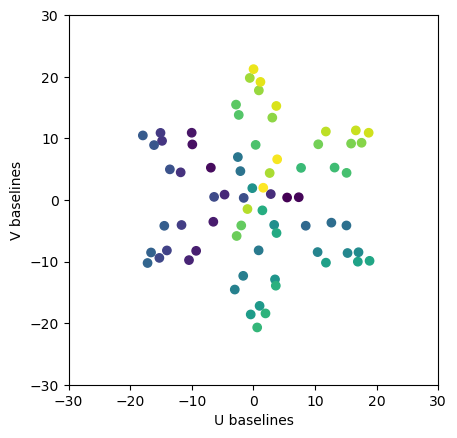

In [76]:
plt.scatter(u,v,c=np.arange(len(u)))
plt.xlim(-30,30)
plt.ylim(-30,30)
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel("U baselines")
plt.ylabel("V baselines")

## Baseline ripple: 

Let's define a parametrized systematic; one which we may know some parameters but want to fit for alongside our relevant stellar parameters. This baseline ripple is a sine function of the baseline. 

### Non hierarchical (ensemble calibration with fixed systematic)

First, we demonstrate that we are able to recover the period of the ripple systematic alongside the stellar diameters simultaneously:

Text(0, 0.5, 'y')

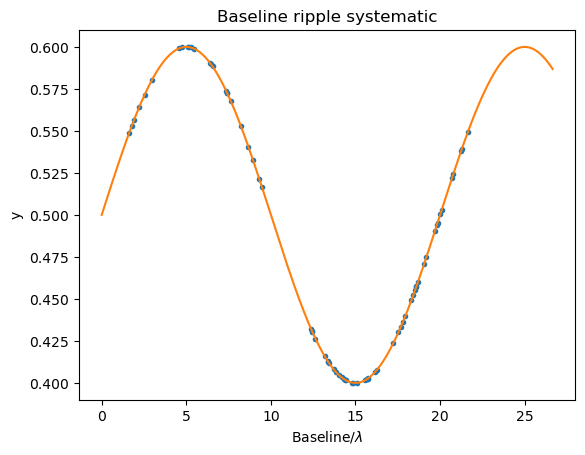

In [77]:
x0 = np.linspace(0, jnp.max(x)+5.0, 200)

def ripple(xs,period):
    return 0.5 + 0.1*(jnp.sin(2*np.pi*xs/period))

p = 20
plt.plot(x,ripple(x,p),'.')
plt.plot(x0,ripple(x0,p))
plt.title("Baseline ripple systematic")
plt.xlabel(r"Baseline/$\lambda$")
plt.ylabel("y")

In [78]:
np.random.seed(42)
num_stars = 5
sigmas = np.random.uniform(5,20,num_stars)
#parameters of the Gaussian

# For reproducibility, let's set the random number seed and generate the data:

yerr = 0.05

systematic = ripple(x,20)
systematic_model = ripple(x0,20)

#gaussian
y = np.exp(-((x)**2)/(2*sigmas[np.newaxis,:].T**2))*systematic + yerr * np.random.randn(num_stars, x.shape[0])


# Then save the *true* line.
x0 = np.linspace(0, jnp.max(x)+5.0, 200)
y0 = np.exp(-((x0)**2)/(2*sigmas[np.newaxis,:].T**2))

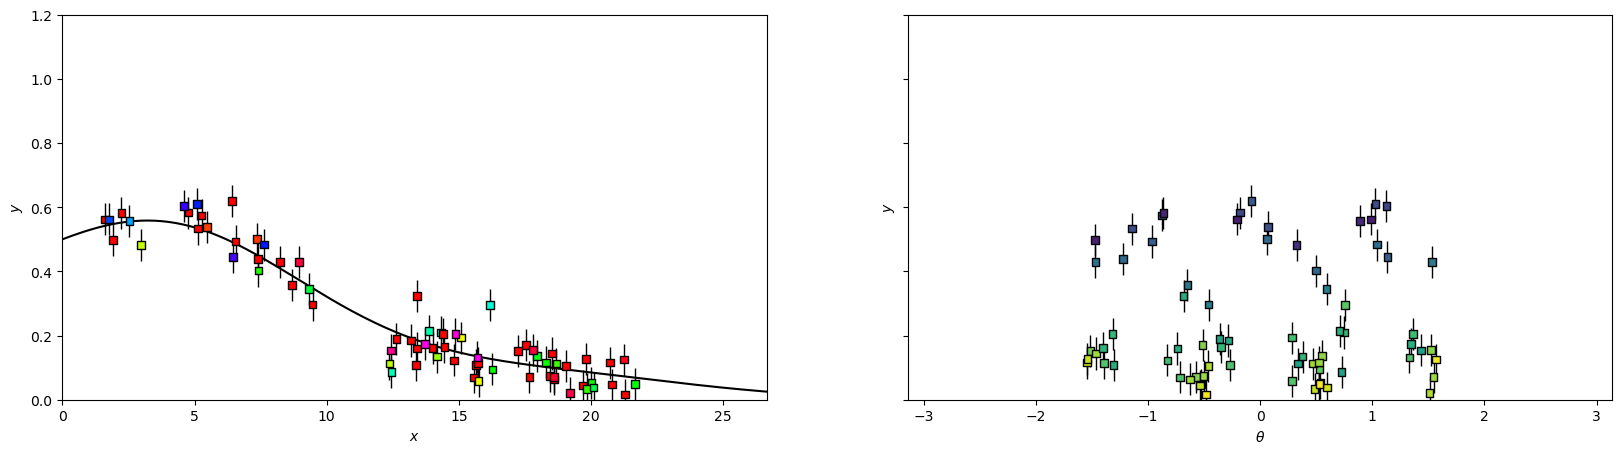

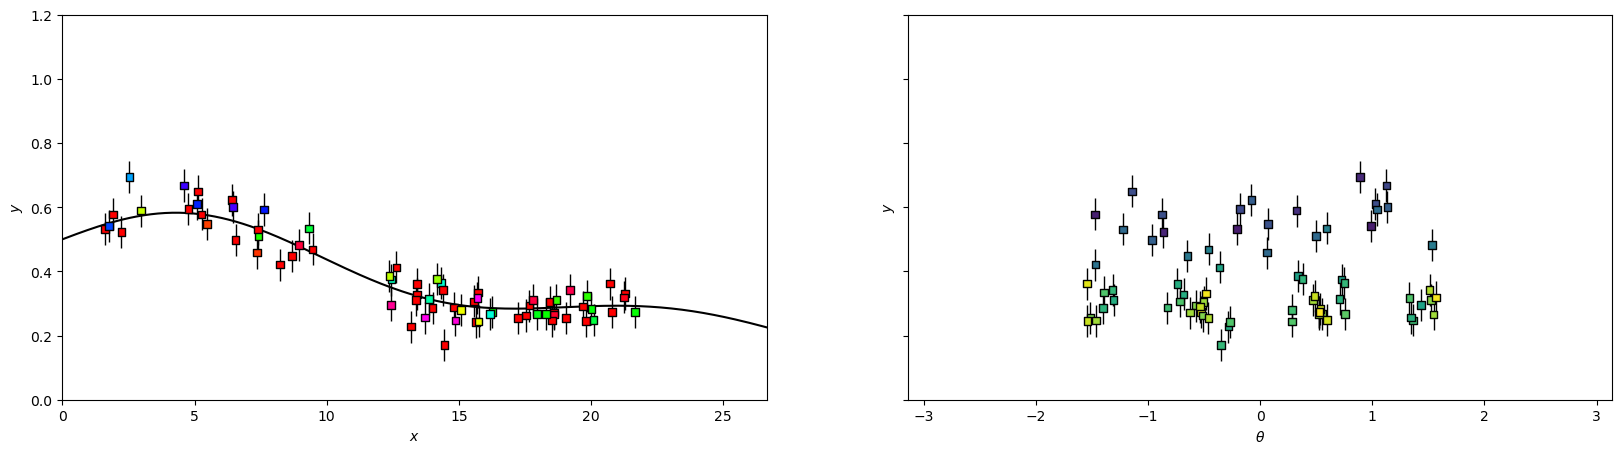

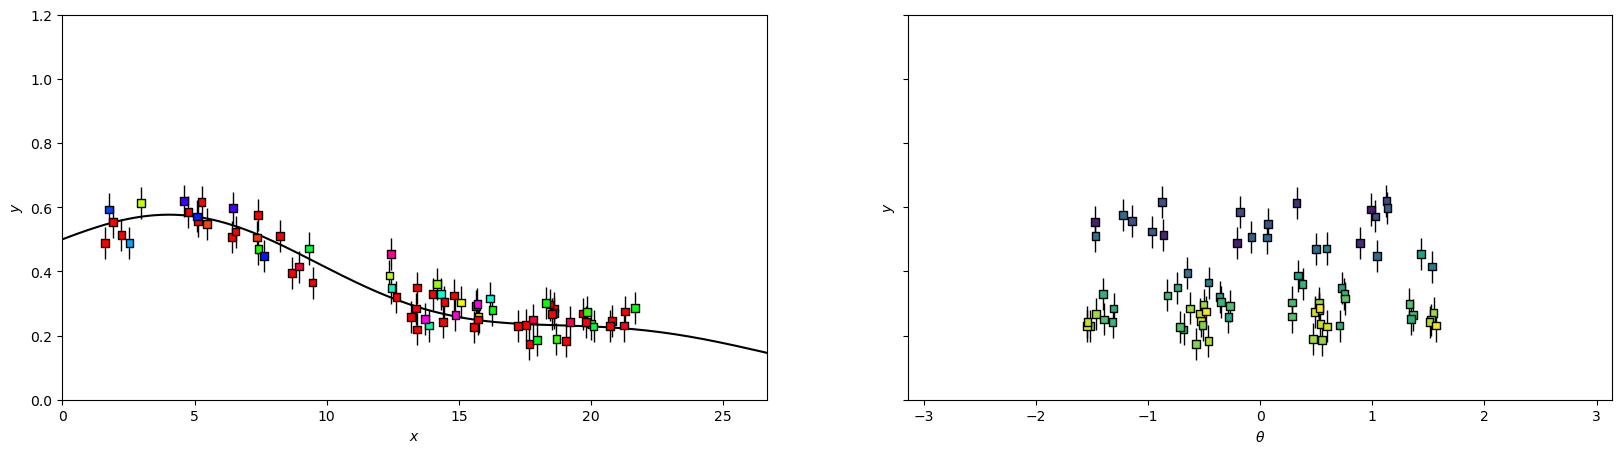

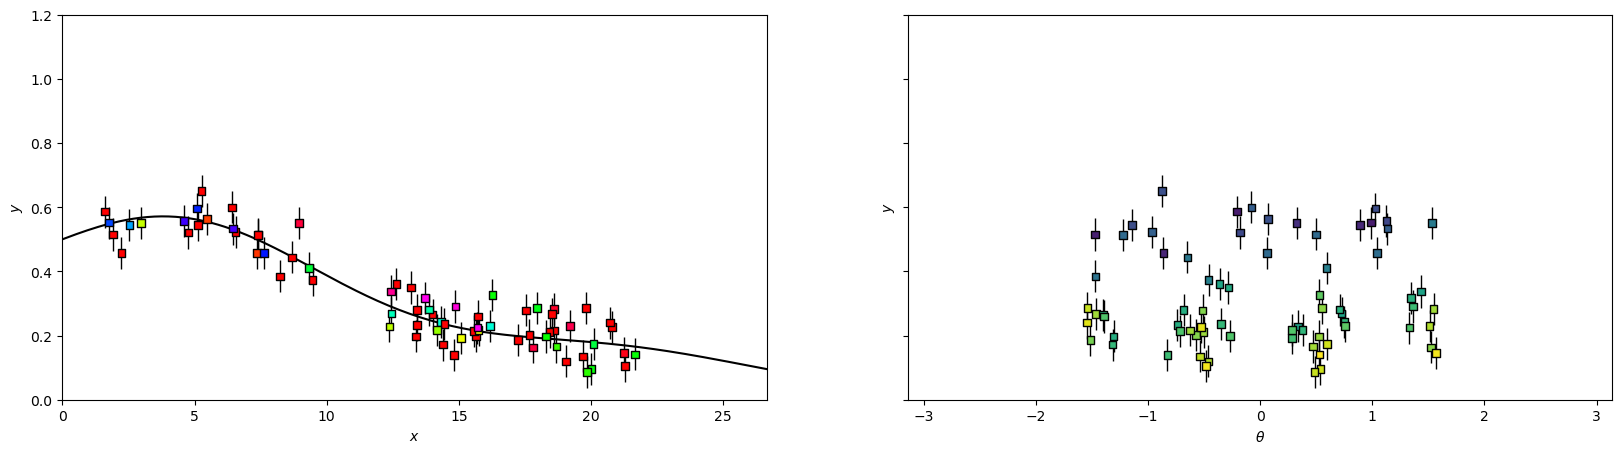

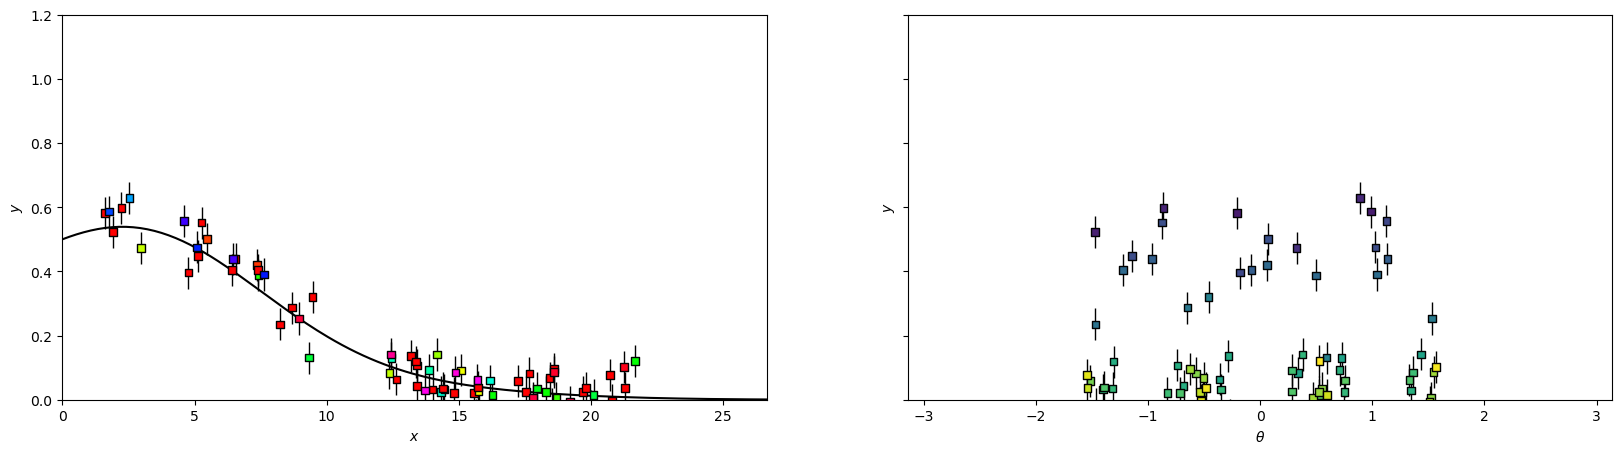

In [79]:
cmap = plt.get_cmap("hsv")
cmap2 = plt.get_cmap("viridis")

def plot_data(x, y, x0, y0, yerr):
    fig, ax = plt.subplots(1,2, figsize=(20,5), sharey=True)
    
    ax[0].errorbar(x, y, yerr=yerr, fmt=",k", ms=0, capsize=0, lw=1, zorder=999)
    ax[0].scatter(x, y, marker="s", s=30, edgecolor="k", zorder=1000, c=cmap(theta/theta.max()))
    ax[0].plot(x0, y0, color="k", lw=1.5)
    ax[0].set_xlabel("$x$")
    ax[0].set_ylabel("$y$")
    ax[0].set_ylim(0, 1.2)
    ax[0].set_xlim(0, jnp.max(x0))
    
    ax[1].errorbar(theta, y, yerr=yerr, fmt=",k", ms=0, capsize=0, lw=1, zorder=999)
    ax[1].scatter(theta, y, marker="s", s=30, edgecolor="k", zorder=1000, c=cmap2(x/x.max()))
    ax[1].set_xlabel(r"$\theta$")
    ax[1].set_ylabel("$y$")
    ax[1].set_ylim(0, 1.2)
    ax[1].set_xlim(-np.pi, np.pi)



for i, sigma in enumerate(sigmas):
    plot_data(x,y[i], x0, y0[i]*systematic_model, yerr)

In [80]:
def gaussian_model(u,v,sigma):
    x = jnp.hypot(u,v)
    theta = jnp.arctan(v/u)
    
    return jnp.exp(-((x)**2)/(2*sigma**2))

def model_multi_systematic(u,v, yerr, y=None):
    # These are the parameters that we're fitting and we're required to define explicit
    # priors using distributions from the numpyro.distributions module.
    period = numpyro.sample("period", dist.Uniform(10, 30))

    sys = numpyro.deterministic("sys",ripple(jnp.hypot(u,v),period))

    with numpyro.plate("stars", y.shape[0],dim=-2):
        sigma = numpyro.sample("diam", dist.Uniform(0, 20))
    
    gm = numpyro.deterministic('gm',gaussian_model(u,v,sigma)*sys)
        
    with numpyro.plate("data",y.shape[1],dim=-1):
        return numpyro.sample("y", dist.Normal(gm, yerr), obs=y)

In [81]:
sampler = infer.MCMC(
    infer.NUTS(model_multi_systematic),
    num_warmup=2000,
    num_samples=2000,
    num_chains=2,
    progress_bar=True,
)
%time sampler.run(jax.random.PRNGKey(0), u, v, yerr, y=y)

/Users/uqsdhola/opt/anaconda3/lib/python3.9/site-packages/jax/linear_util.py:167: UserWarning: Missing a plate statement for batch dimension -2 at site 'y'. You can use `numpyro.util.format_shapes` utility to check shapes at all sites of your model.
  ans = self.f(*args, **dict(self.params, **kwargs))


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

CPU times: user 2.09 s, sys: 56.6 ms, total: 2.14 s
Wall time: 1.96 s


In [82]:
inf_data = az.from_numpyro(sampler)
az.summary(inf_data)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"diam[0, 0]",10.546,0.233,10.117,10.987,0.004,0.003,3599.0,2824.0,1.0
"diam[1, 0]",18.954,0.526,18.087,19.970,0.010,0.007,2143.0,918.0,1.0
"diam[2, 0]",16.982,0.479,16.046,17.836,0.008,0.006,3334.0,2083.0,1.0
"diam[3, 0]",14.334,0.340,13.673,14.959,0.005,0.004,4491.0,2975.0,1.0
"diam[4, 0]",7.666,0.200,7.291,8.041,0.003,0.002,4546.0,3043.0,1.0
...,...,...,...,...,...,...,...,...,...
sys[67],0.404,0.003,0.400,0.408,0.000,0.000,3067.0,2789.0,1.0
sys[68],0.479,0.012,0.456,0.500,0.000,0.000,3016.0,2708.0,1.0
sys[69],0.541,0.012,0.519,0.564,0.000,0.000,3016.0,2708.0,1.0
sys[70],0.566,0.004,0.560,0.573,0.000,0.000,3016.0,2708.0,1.0


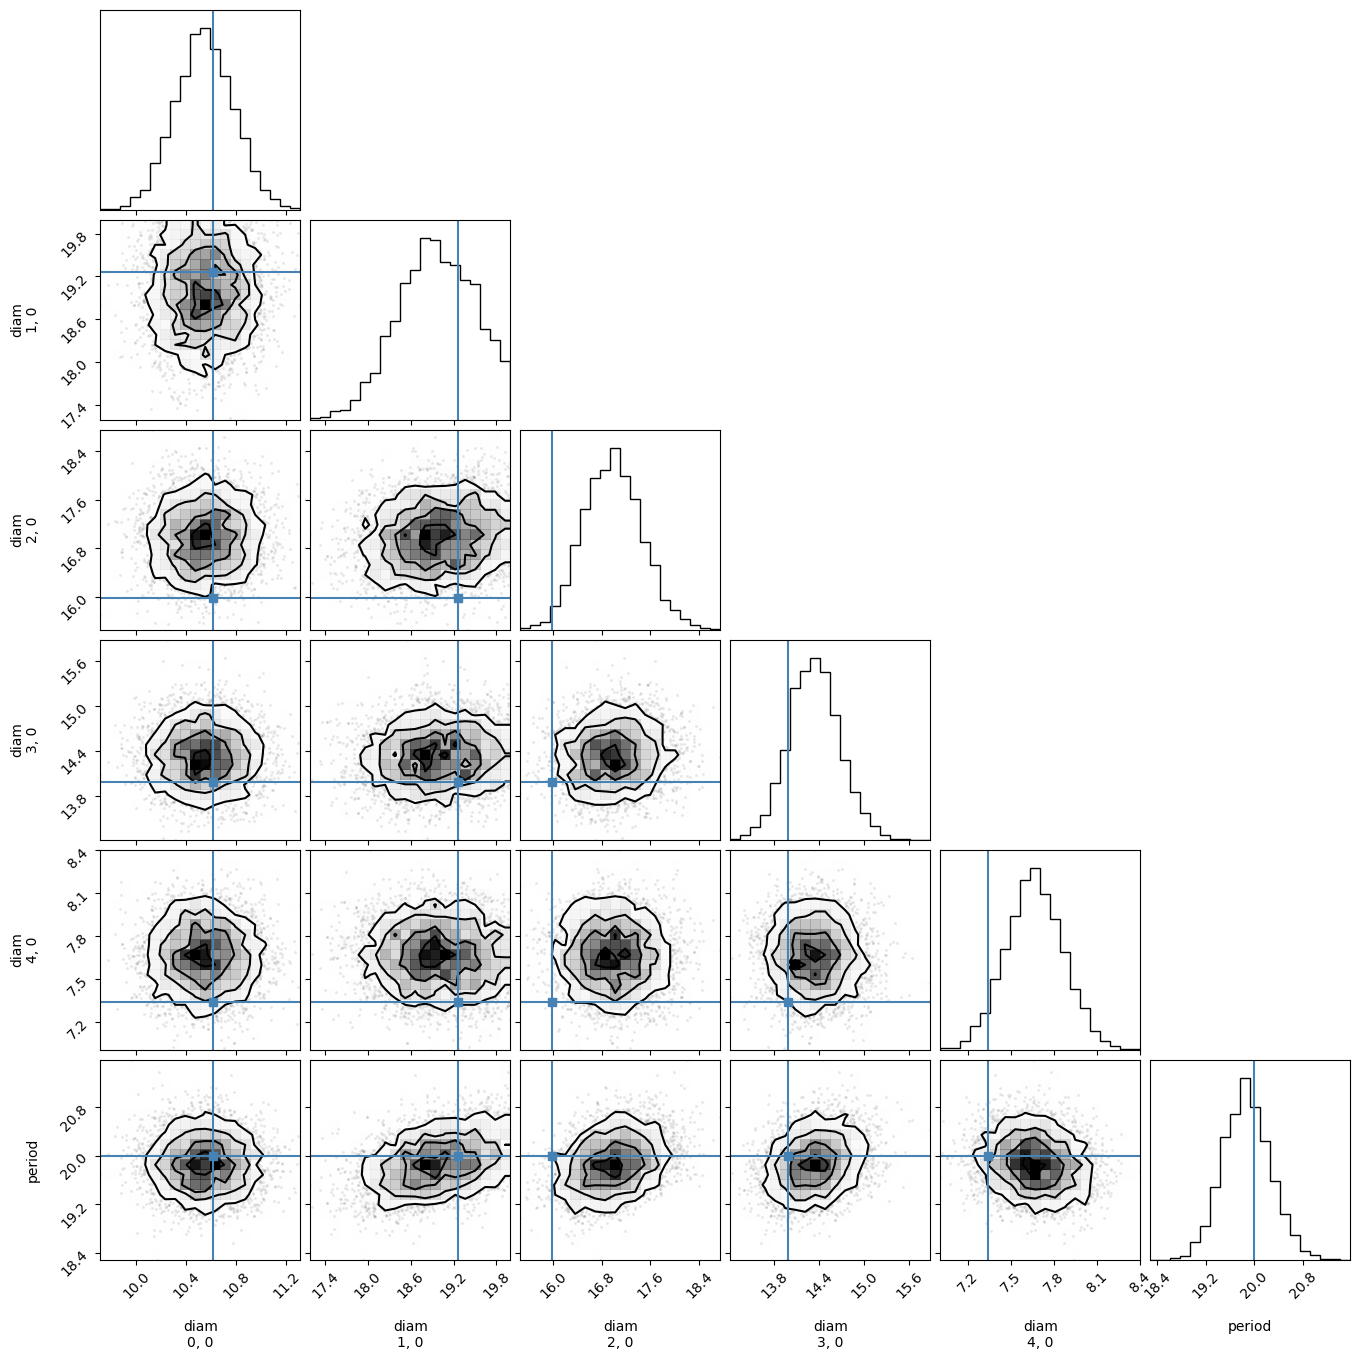

In [83]:
corner.corner(inf_data, var_names=["diam", "period"], truths=[*sigmas,20]);

As can be seen, we are able to recover all parameters admirably!

### Hierarchical model:

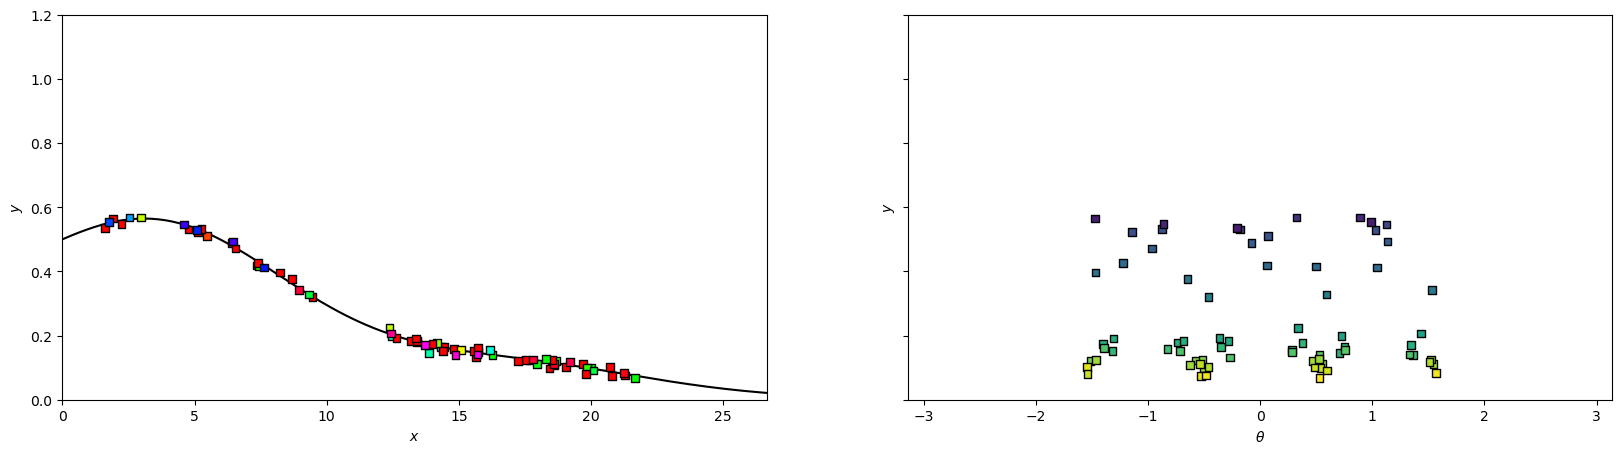

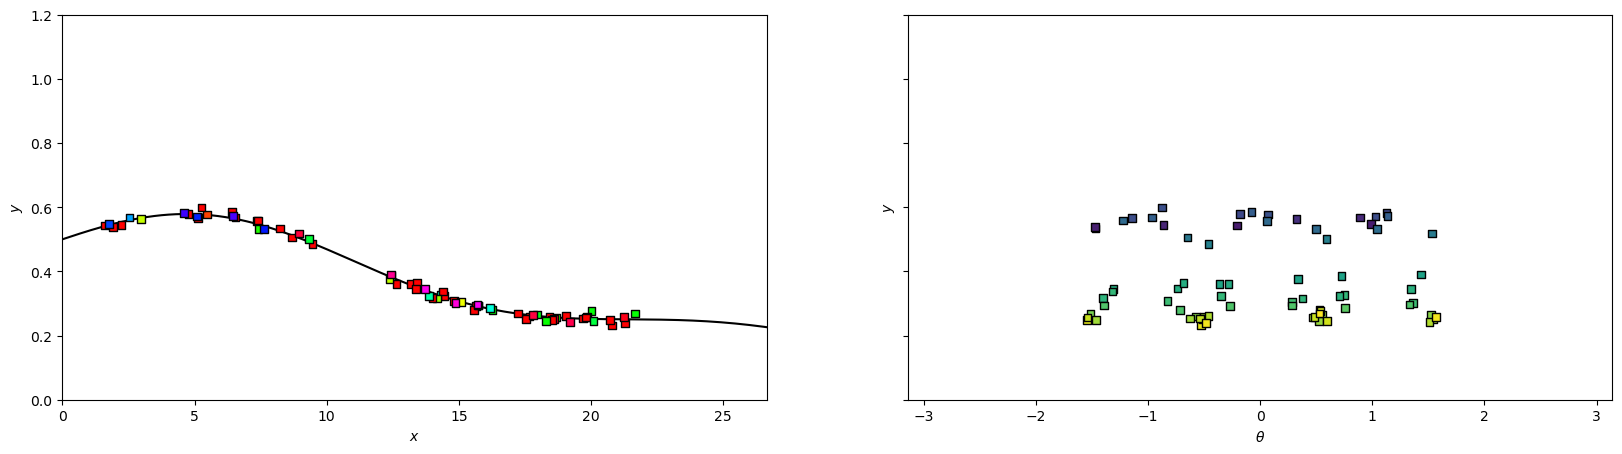

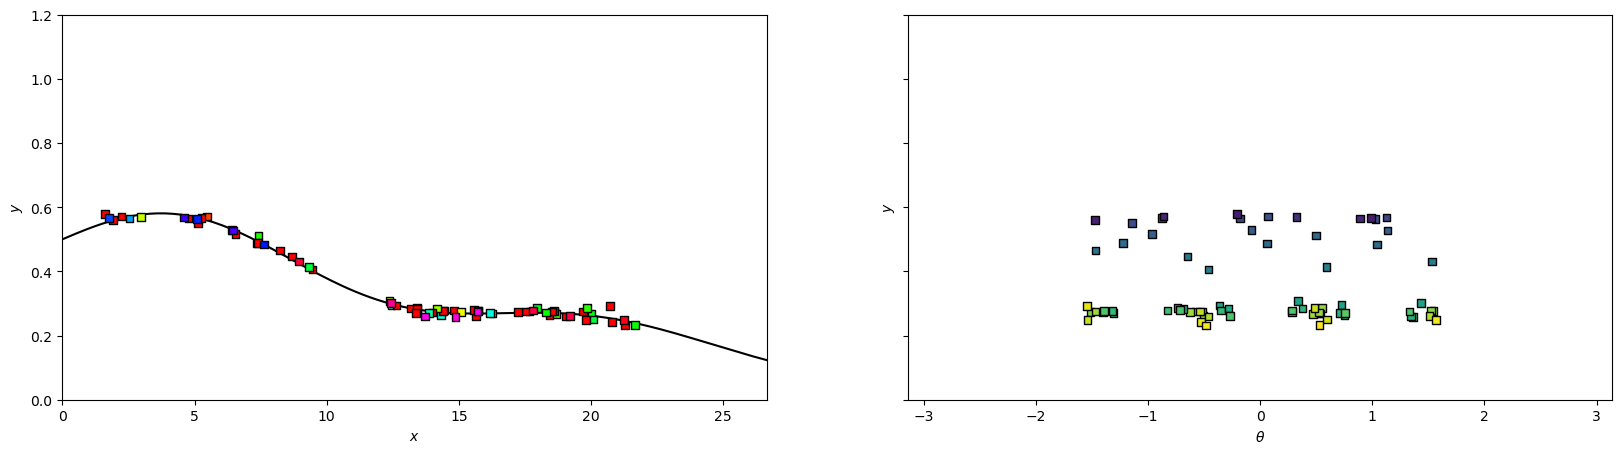

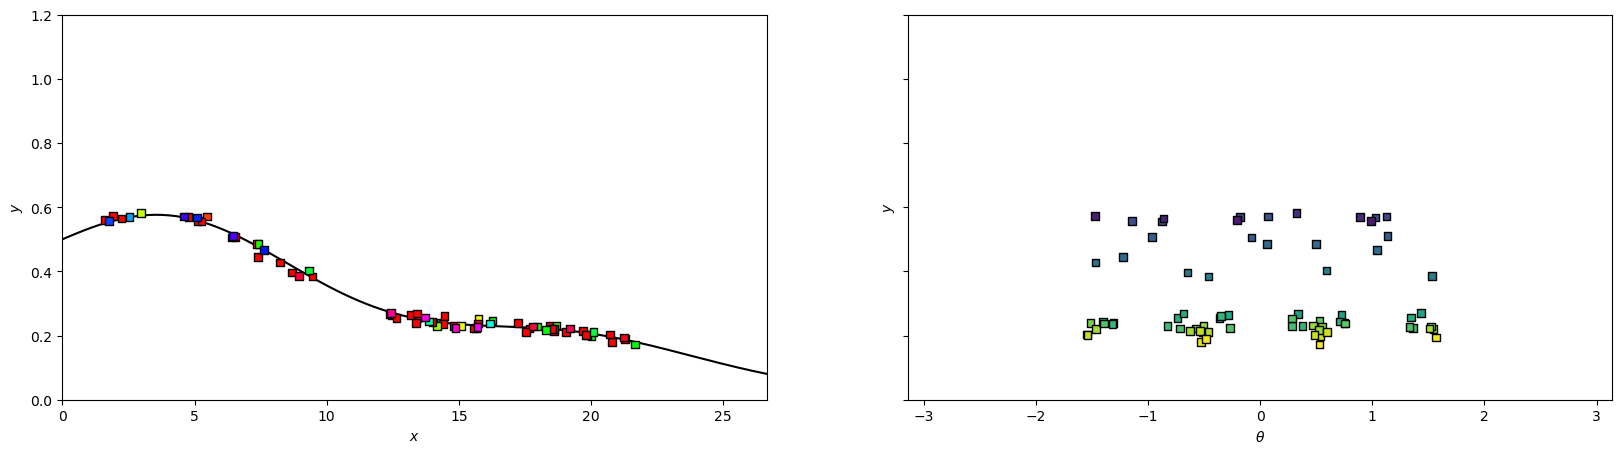

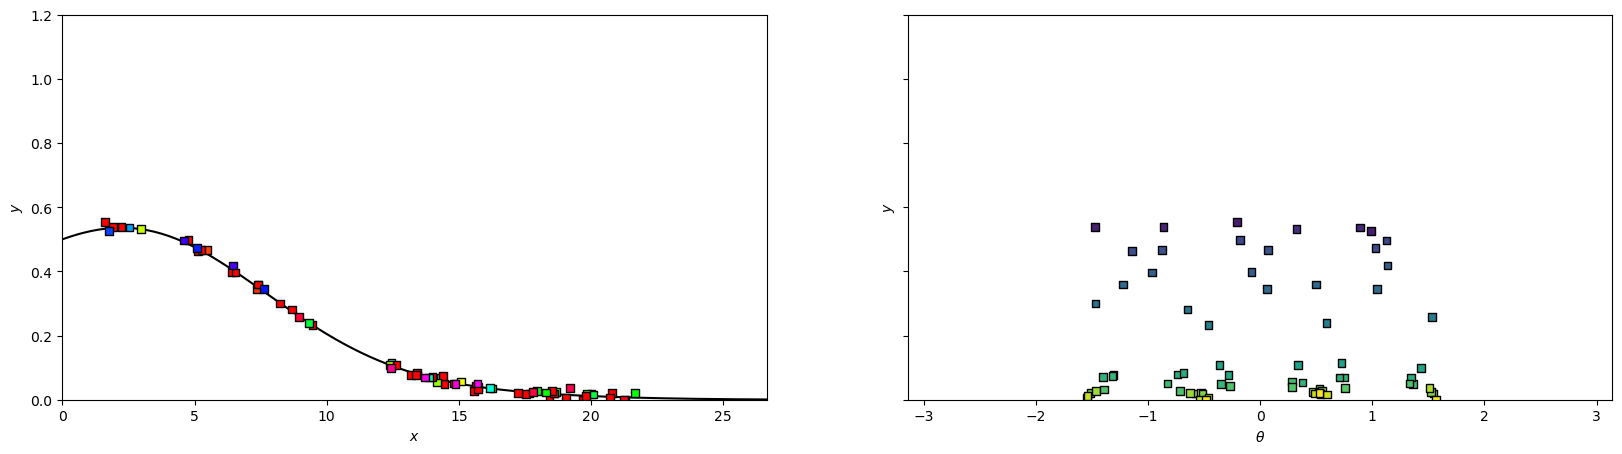

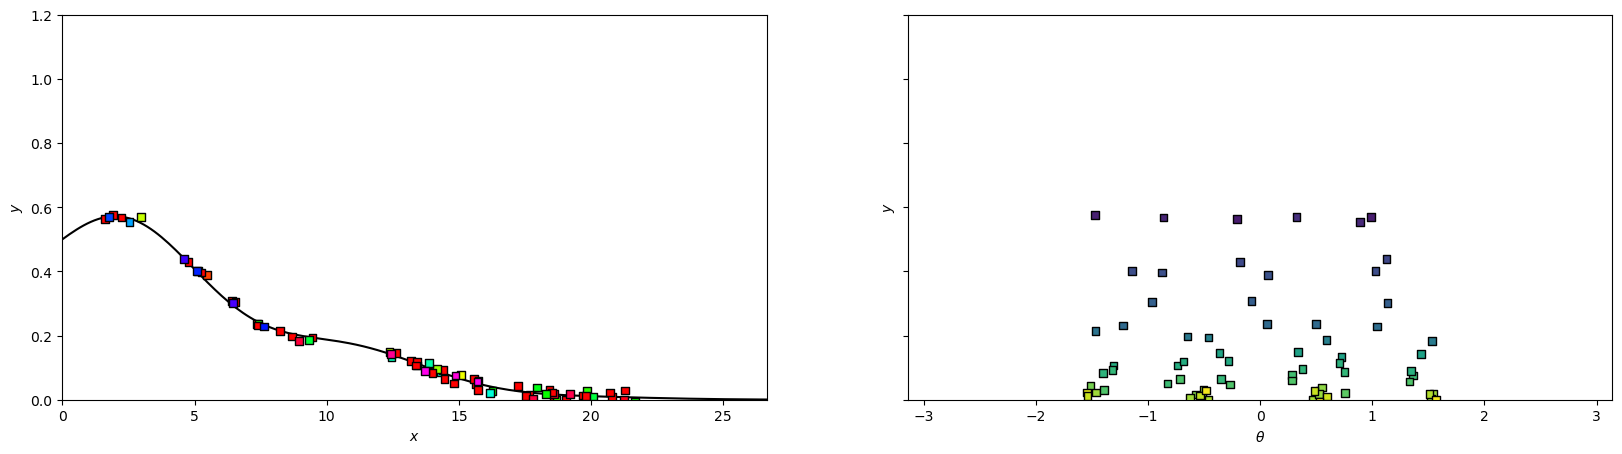

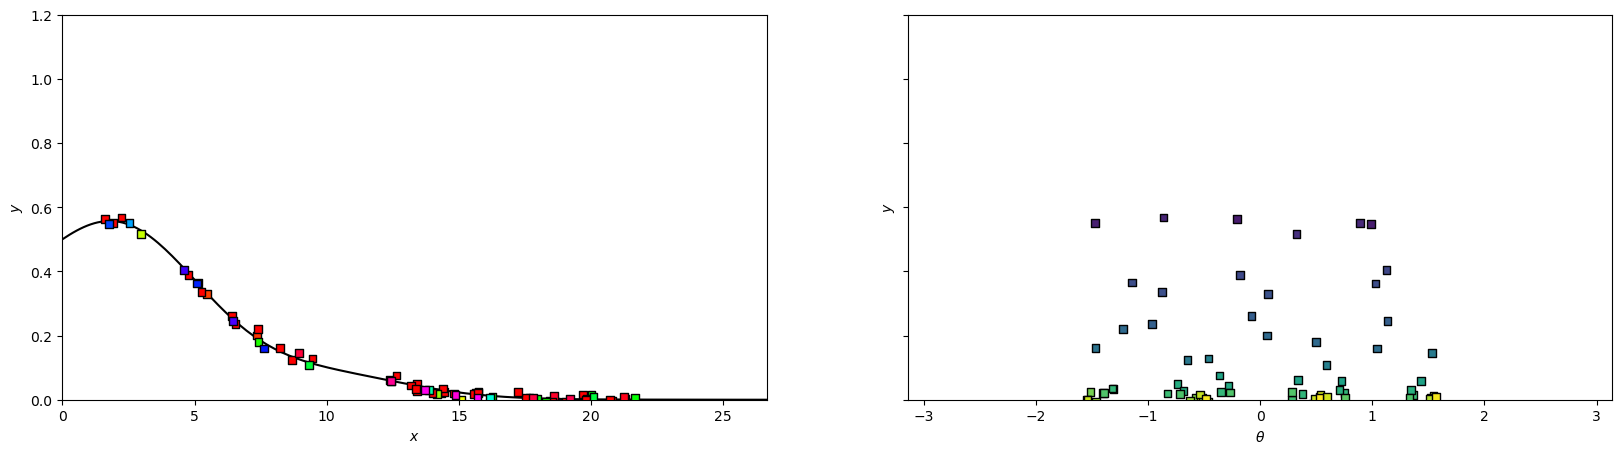

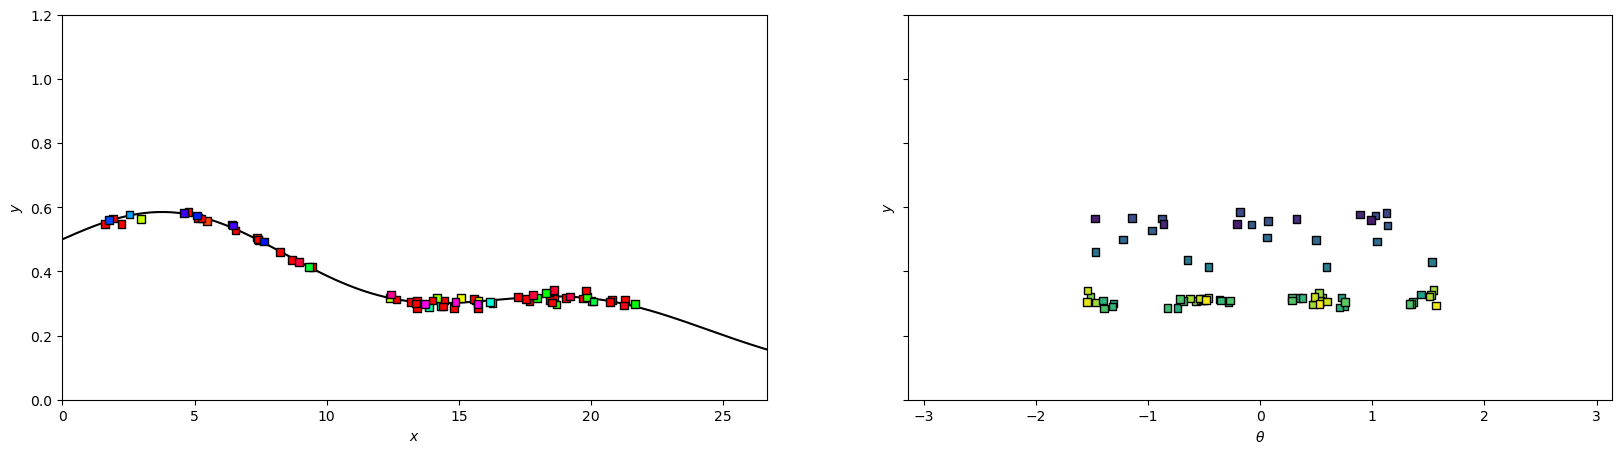

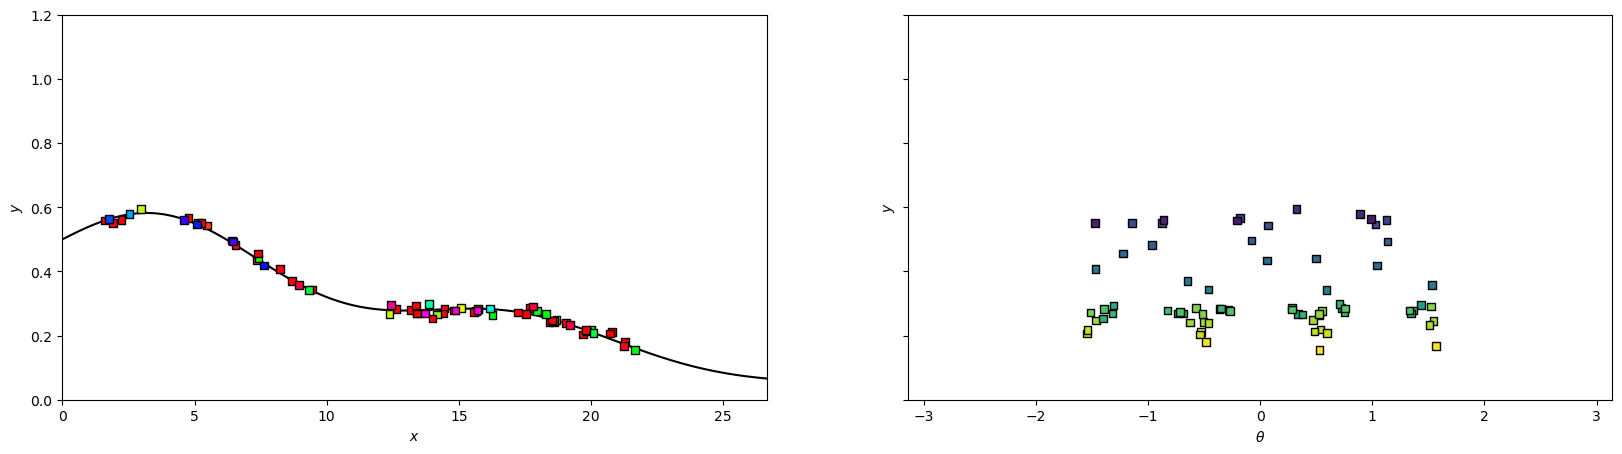

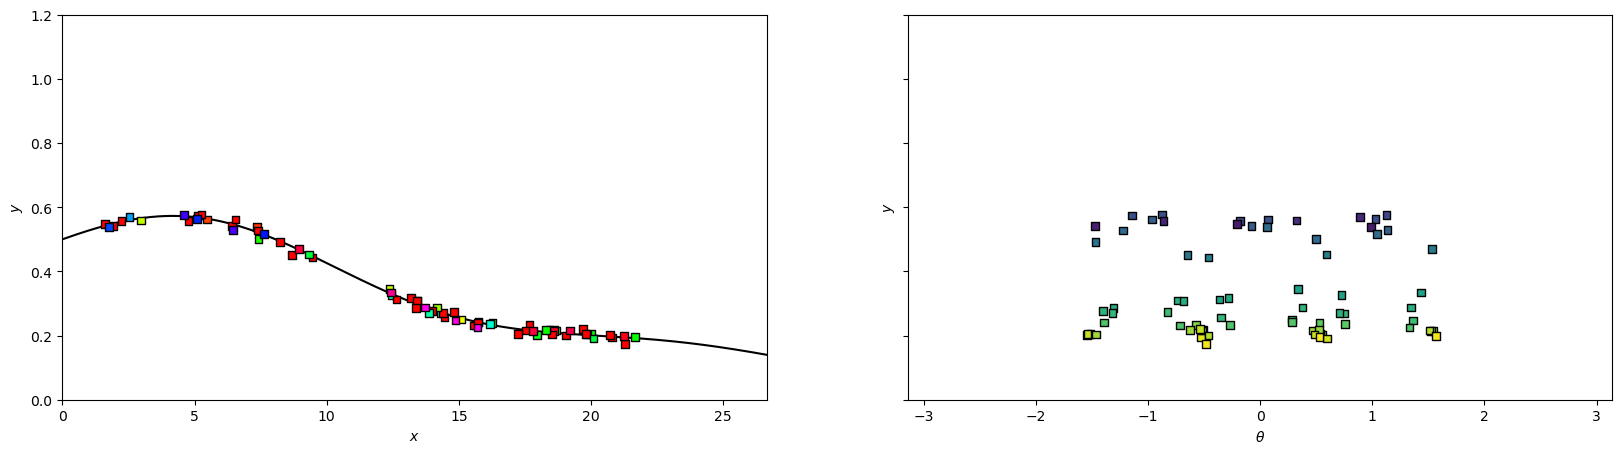

In [153]:
np.random.seed(42)
num_stars = 10
sigmas = np.random.uniform(5,20,num_stars)
#parameters of the Gaussian

# For reproducibility, let's set the random number seed and generate the data:

yerr = 0.01

x0 = np.linspace(0, jnp.max(x)+5.0, 200)

periods = 20 + 5*np.random.normal(size=num_stars)

ripple_vmap = jax.vmap(ripple, in_axes=[None,0])
systematic = ripple_vmap(x,periods)
systematic_model = ripple_vmap(x0,periods)

#gaussian
y = np.exp(-((x)**2)/(2*sigmas[np.newaxis,:].T**2))*systematic + yerr * np.random.randn(num_stars, x.shape[0])
    
# Then save the *true* line.
y0 = np.exp(-((x0)**2)/(2*sigmas[np.newaxis,:].T**2))

for i, sigma in enumerate(sigmas):
    plot_data(x,y[i], x0, y0[i]*systematic_model[i], yerr)

In [164]:
def model_hierarchical(u, v, yerr, y=None):
    # These are the parameters that we're fitting and we're required to define explicit
    # priors using distributions from the numpyro.distributions module.
    
    
    # Then we specify the sampling distribution for the data, or the likelihood function.
    # Here we're using a numpyro.plate to indicate that the data are independent. This
    # isn't actually necessary here and we could have equivalently omitted the plate since
    # the Normal distribution can already handle vector-valued inputs. But, it's good to
    # get into the habit of using plates because some inference algorithms or distributions
    # can take advantage of knowing this structure.

    with numpyro.plate("stars", y.shape[0],dim=-2):
        sigma = numpyro.sample("diam", dist.Uniform(5, 20))
    sys = numpyro.deterministic("sys",ripple(jnp.hypot(u,v),20))
    gm = numpyro.deterministic('gm',gaussian_model(u,v,sigma))
        
    with numpyro.plate("data",y.shape[1],dim=-1):
        return numpyro.sample("y", dist.Normal(gm*sys, yerr), obs=y)

In [165]:
# Using the model above, we can now sample from the posterior distribution using the No
# U-Turn Sampler (NUTS).
sampler = infer.MCMC(
    infer.NUTS(model_hierarchical),
    num_warmup=2000,
    num_samples=2000,
    num_chains=2,
    progress_bar=True,
)
%time sampler.run(jax.random.PRNGKey(0), u, v, yerr, y=y)

/Users/uqsdhola/opt/anaconda3/lib/python3.9/site-packages/jax/linear_util.py:167: UserWarning: Missing a plate statement for batch dimension -2 at site 'y'. You can use `numpyro.util.format_shapes` utility to check shapes at all sites of your model.
  ans = self.f(*args, **dict(self.params, **kwargs))


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

CPU times: user 1.61 s, sys: 54.3 ms, total: 1.67 s
Wall time: 1.53 s


In [166]:
import pandas as pd
pd.set_option('display.max_rows', 10)
inf_data = az.from_numpyro(sampler)
# az.summary(inf_data)

In [167]:
corner.corner(inf_data, truths=[periods], var_names=['period']);

KeyError: 'var names: "[\'period\'] are not present" in dataset'

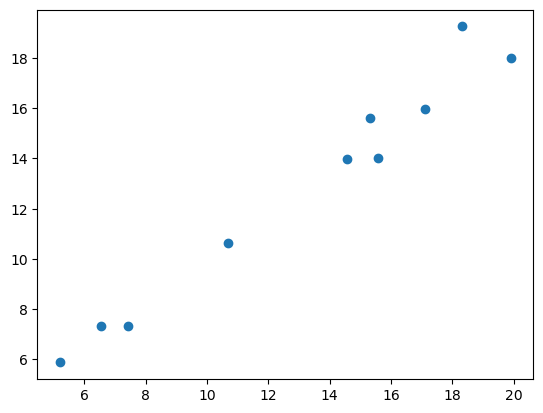

In [168]:
plt.scatter(np.mean(inf_data.posterior.diam, axis=(0,1)), sigmas)